# Milestone 3

El objetivo de este *milestone* es calcular la extrapolación de Richardson y estimar el ratio de convergencia de los esquemas temporales dados.  
Para ello, se resuelve el mismo problema de Cauchy para distintos valores de $\Delta t$ para un mismo intervalo de tiempo y órbita y se calcula

$$
E_i^{n} = \| U_i^{n} - U_{\text{ref}}^{n} \|
$$

para el $\Delta t_i$ correspondiente.

La extrapolación de Richardson viene dada por:

$$
R = \frac{E^{n}}{1 - \frac{1}{2^q}}
$$

donde $q$ es el orden del método numérico.  
Para estimar este orden, se puede usar la expresión:

$$
q \approx \frac{\log{\left( \frac{E_i}{E_j} \right)}}{\log{\left( \frac{\Delta t_i}{\Delta t_j} \right)}}
$$
Con lo cual, tomando una regresión lineal de $\log{E}$ y sus $\log{N}$ asociados, donde $N$ es la cantidad de puntos del mallado temporal, se puede aproximar $q$.
Los métodos numéricos de *milestones* anteriores se encuentran en `temporal_schemes.py` y `differential_equation.py`. Al final de este notebook se muestra un plot de la extrapolación de Richardson valor aproximado de $q$ respecto al número de pasos de tiempo para todos los métodos numéricos de las *milestones* anteriores. Se ve como las pendientes en escala logarítmica de la aproximación de Richardson están relacionadas con el orden del esquema temporal.

In [11]:
from numpy import array, concatenate, zeros, linspace, log, polyfit
from numpy.linalg import norm, solve, LinAlgError
import matplotlib.pyplot as plt
from temporal_schemes import Cauchy_problem, Euler, Crank_Nicolson, RK4, Inverse_Euler
from differential_equation import F

In [8]:
def richardson_extrapolation(F, U0, t1, temporal_scheme, known_q = True, **kwargs):
    N1 = len(t1)
    t2 = linspace(t1[0], t1[N1-1], 2*(N1)-1)
    U_1 = Cauchy_problem(F, U0, t1, temporal_scheme, **kwargs)
    U_2 = Cauchy_problem(F, U0, t2, temporal_scheme, **kwargs)
    N2 = len(t2)
    error = zeros(N1)
    if known_q == True:
        if temporal_scheme == Euler:
            q = 1
        elif temporal_scheme == Crank_Nicolson:
            q = 2
        elif temporal_scheme == RK4:
            q = 4
        elif temporal_scheme == Inverse_Euler:
            q = 1
        else:
            print("ERROR: Temporal scheme not available.")
            return -1
        for n in range(0, N1):
            error[n] = norm(U_1[n,:]-U_2[2*n,:])/(1-1/2**q)
    else:
        for n in range(0, N1):
            error[n] = norm(U_1[n,:]-U_2[2*n,:])
    
    return error

## Ratio de convergencia

In [23]:
def convergence_rate(F, U0, t1, temporal_scheme, N_ini, N_refinements=6, **kwargs):
    N = N_ini
    errors = zeros(N_refinements)
    log_N = zeros(N_refinements)

    t_coarse = linspace(t1[0], t1[-1], N)
    U1 = Cauchy_problem(F, U0, t_coarse, temporal_scheme, **kwargs)

    for i in range(N_refinements):

        N_fine = 2*N - 1
        t_fine = linspace(t1[0], t1[-1], N_fine)
        U2 = Cauchy_problem(F, U0, t_fine, temporal_scheme, **kwargs)

        errors[i] = norm(U2[-1,:] - U1[-1,:])
        log_N[i] = log(N_fine)

        U1 = U2
        N = N_fine

    log_errors = log(errors)
    return log_N, log_errors
        


In [25]:
def plot_log_E_vs_log_N(F, U0, t1, temporal_scheme, N_ini, N_refinements=6, **kwargs):
    log_N, log_E = convergence_rate(F, U0, t1, temporal_scheme, N_ini, tol_jacobian=1e-9, N_max=10000, newton_tol=1e-9)
    q,K = polyfit(log_N, log_E, 1)
    regression_line = q*log_N + K
    x_text = log_N[0] + 0.60*(log_N[-1] - log_N[0]) 
    y_text = q * x_text + K     
                       
    plt.scatter(log_N, log_E)
    plt.plot(log_N, regression_line)
    plt.text(x_text, y_text, f"ratio convergencia: {-q:.2f}\n")
    plt.xlabel("log(N)")
    plt.ylabel("log(E)")
    plt.title(f"log(E) vs log(N) para {temporal_scheme.__name__}")
    plt.show()
    return


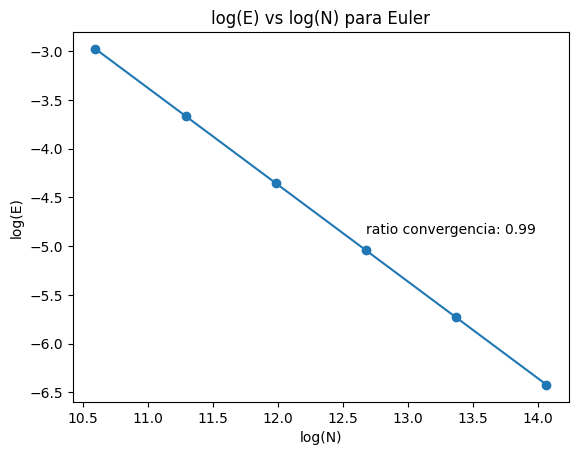

In [26]:
U0 = array([1,0,0,1])
t1 = linspace(0, 10, 1000)
plot_log_E_vs_log_N(F, U0, t1, Euler, 20000)

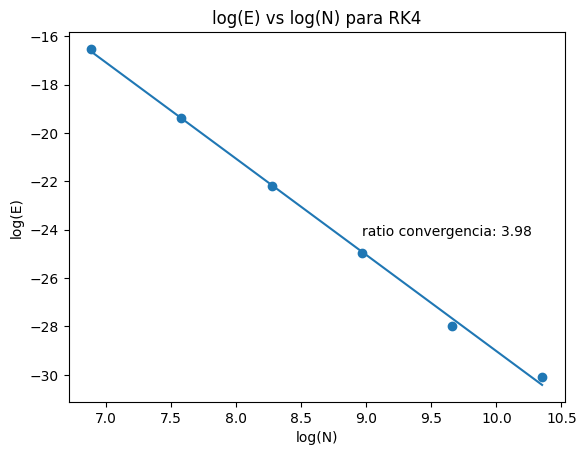

In [35]:
plot_log_E_vs_log_N(F, U0, t1, RK4, 490)

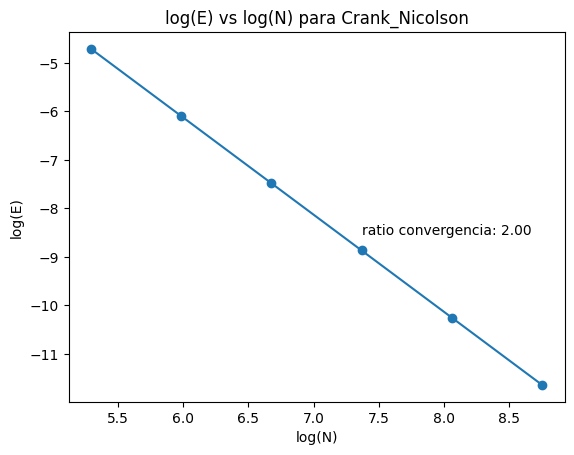

In [36]:
plot_log_E_vs_log_N(F, U0, t1, Crank_Nicolson, 100)

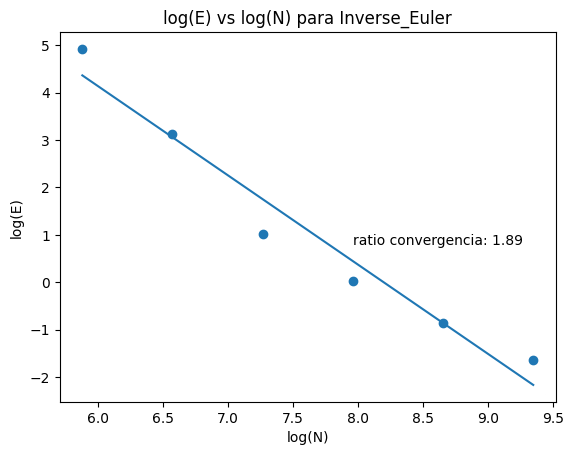

In [39]:
plot_log_E_vs_log_N(F, U0, t1, Inverse_Euler, 180)